# Building Regression Models

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import pickle 

In [2]:
# Open pickled dataframe from EDA
with open("datasets/anime_normal.p", "rb") as f:
    df = pickle.load(f)
    f.close()
df.head(3)

,rating,average_episode_duration,num_episodes,title_len,synopsis_len,synop_pol,title_pol,synop_subj,title_subj,num_related_anime,...,Kyoto Animation,Shaft,DLE,other_studio,Drama,Kids,Shounen,Sci-Fi,Shoujo,other_genres
8,8.98,1500,22,30,802,0.068571,0.0,0.386190,0.0,2,...,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1
9,8.98,1440,12,14,844,-0.050000,0.0,0.487500,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,1.0,1.0,0.0,1
10,8.95,1460,24,17,786,-0.030022,0.0,0.568063,0.0,3,...,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1


The "Popularity" column is not a feature, it is for weights. So, we will remove it and reset our indices. Then, we will create our X and y dataframes, containing our features and target, respectively.

In [3]:
# Popularity is for weights, not a feature, so we remove it and reset indices
df = df.drop('popularity', axis=1)
df = df.reset_index(drop=True)

# Define features and target
features = ['average_episode_duration', 'num_episodes', 'title_len', 'synopsis_len',
       'synop_pol', 'title_pol', 'synop_subj', 'title_subj',
       'num_related_anime', 'num_genres', 'num_studios', 'pic_colorfulness',
       'EMT Squared', 'Bones', 'Production I.G', 'A-1 Pictures',
       'Madhouse', 'Kyoto Animation', 'Shaft', 'DLE', 'other_studio', 'Drama',
       'Kids', 'Shounen', 'Sci-Fi', 'Shoujo', 'other_genres', 'source']

target = 'rating'

# Create X and y dataframes
X = df[features]
y = df[target]

# Creating our Preprocessors

In [4]:
# Import preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [5]:
X.columns

Index(['average_episode_duration', 'num_episodes', 'title_len', 'synopsis_len',
       'synop_pol', 'title_pol', 'synop_subj', 'title_subj',
       'num_related_anime', 'num_genres', 'num_studios', 'pic_colorfulness',
       'EMT Squared', 'Bones', 'Production I.G', 'A-1 Pictures', 'Madhouse',
       'Kyoto Animation', 'Shaft', 'DLE', 'other_studio', 'Drama', 'Kids',
       'Shounen', 'Sci-Fi', 'Shoujo', 'other_genres', 'source'],
      dtype='object')

In [6]:
cont_cols = ['average_episode_duration', 'num_episodes', 'title_len', 'synopsis_len',
       'synop_pol', 'title_pol', 'synop_subj', 'title_subj',
       'num_related_anime', 'num_genres', 'num_studios', 'pic_colorfulness']

cat_cols = ['EMT Squared', 'Bones', 'Production I.G', 'A-1 Pictures',
       'Madhouse', 'Kyoto Animation', 'Shaft', 'DLE', 'other_studio', 'Drama',
       'Kids', 'Shounen', 'Sci-Fi', 'Shoujo', 'other_genres', 'source']

cont_index = [X.columns.get_loc(c) for c in cont_cols]
cat_index = [X.columns.get_loc(c) for c in cat_cols]
source_index = X.columns.get_loc('source')

imp_preproc = ColumnTransformer(remainder='passthrough', transformers=[
    ('imp_cont', SimpleImputer(strategy='mean'), cont_index),
    ('imp_cat', SimpleImputer(strategy='most_frequent'), cat_index),
])

source_preproc = ColumnTransformer(remainder='passthrough', transformers=[
    ('ord', OrdinalEncoder(handle_unknown='ignore'), [source_index]),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), [source_index])
])

drop_preproc = ColumnTransformer(remainder='drop', transformers=[
    ('drop_first', SimpleImputer(strategy='most_frequent'), [i for i in range(1,32)]),
])

# Hyperparameter Tuning with GridSearchCV

In [7]:
from sklearn.model_selection import GridSearchCV, ParameterGrid, KFold

In [8]:
# Parameter grid for GridSearchCV
model_grid = {
    'linear_reg': {
        'model':LinearRegression(),
        'params': {
            'normalize': [True, False]
        }
    },
    'lasso': {
        'model':Lasso(max_iter=50000),
        'params': {
            # 'alpha': np.logspace(-6, 6, 50)
            'alpha': [0.0004, 0.00045, 0.0004941713361323833, 0.00055, 0.0006,]
        }
    },
    'ridge': {
        'model':Ridge(max_iter=50000),
        'params': {
            # 'alpha': np.logspace(-6, 6, 50)
            'alpha': [0.6, 0.65, 0.7, 0.7543120063354607, 0.8, 0.85, 0.9]
        }
    },
    'random_forest': {
        'model':RandomForestRegressor(random_state=15, n_jobs=3, n_estimators=500),
        'params': {
            'max_depth': [None, 9, 10, 11, 12, 13, 14, 15],
            # 'max_depth': [None, 4, 8, 12, 16, 20, 24, 28],
            'criterion':['mse', 'mae']
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(random_state=15),
        'params': {
            'loss': ['ls', 'lad', 'huber'],
            'criterion':['friedman_mse', 'mse'],
            #'max_depth': [1, 2, 3, 4]
            'max_depth': [2, 3, 4, 5]
        }
    }
}

# Testing our Models

In [9]:
def CV_score(X, y, splits, model):
    scores = []
    CV_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', model)
    ])

    for train_index, test_index in splits:
        X_train = X.iloc[train_index,:]
        X_test = X.iloc[test_index,:]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        CV_imp = SimpleImputer(strategy='mean', missing_values=np.nan)
        y_train = CV_imp.fit_transform(np.array(y_train).reshape(-1, 1))
        y_test = CV_imp.transform(np.array(y_test).reshape(-1, 1))

        CV_pipe.fit(X_train, y_train.ravel())
        scores.append(CV_pipe.score(X_test, y_test))

    return np.average(scores)

In [12]:
results = []

for model_name, mp in model_grid.items():
    avg_scores = []
    model_params = []
    for g in ParameterGrid(mp['params']):
        model = mp['model']
        model.set_params(**g)

        kf = KFold(n_splits=4, shuffle=True, random_state=5)
        splits = kf.split(df)
        score = CV_score(X, y, splits, model)

        avg_scores.append(score)
        model_params.append(g)

    best_index = avg_scores.index(np.max(avg_scores))
    results.append({
        'model': model_name,
        'params':model_params[best_index],
        'score': avg_scores[best_index],
    })
    print(model_name, avg_scores)

results

linear_reg [0.3645589282144065, 0.3645916698517849]
lasso [0.3662821637226986, 0.3663165106875781, 0.36632626494994996, 0.3663103593762465, 0.36628704431411174]
ridge [0.365856061544314, 0.36585697111152415, 0.3658561554553644, 0.36585336239601146, 0.36584951170316393, 0.36584376342919867, 0.36583644948789396]
random_forest [0.409956436620036, 0.4070415041304318, 0.409238802269867, 0.4097949934997668, 0.41030170827516266, 0.41031994822149975, 0.41057607330214774, 0.4104155980277334, 0.4087040026789419, 0.4034621209213637, 0.4050841345148527, 0.4077608826046659, 0.40869220531418804, 0.4090765984674463, 0.40989529430132354, 0.4099008439203835]
gradient_boosting [0.42446558383636557, 0.43875234918821127, 0.44091555194431886, 0.43369342330813576, 0.4147474834765408, 0.4253942689548773, 0.42886656780073473, 0.41999851201552696, 0.42671998744111816, 0.4415954247086979, 0.43943097647097135, 0.4343178458675578, 0.42446558383636557, 0.43875234918821127, 0.44091555194431886, 0.43369342330813576,

[{'model': 'linear_reg',
  'params': {'normalize': False},
  'score': 0.3645916698517849},
 {'model': 'lasso',
  'params': {'alpha': 0.0004941713361323833},
  'score': 0.36632626494994996},
 {'model': 'ridge', 'params': {'alpha': 0.65}, 'score': 0.36585697111152415},
 {'model': 'random_forest',
  'params': {'criterion': 'mse', 'max_depth': 14},
  'score': 0.41057607330214774},
 {'model': 'gradient_boosting',
  'params': {'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3},
  'score': 0.4415954247086979}]

# Feature Importance in the Linear Regressor

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error, median_absolute_error

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

test_imp = SimpleImputer(strategy='mean', missing_values=np.nan)
y_train = test_imp.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = test_imp.transform(np.array(y_test).reshape(-1, 1))

las_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', Lasso(max_iter=50000, alpha=0.0004941713361323833))
    ])

rid_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', Ridge(max_iter=50000, alpha=0.65))
    ])

las_pipe.fit(X_train, y_train)
rid_pipe.fit(X_train, y_train)

print("LASSO REGRESSOR\n==============")
print("R2 Value: ", las_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, las_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, las_pipe.predict(X_test)))

print("\nRIDGE REGRESSOR\n==============")
print("R2 Value: ", rid_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, rid_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, rid_pipe.predict(X_test)))

LASSO REGRESSOR
R2 Value:  0.3842259940214088
Mean Squared Error:  0.37143763456988593
Median Absolute Error:  0.4105713980942882

RIDGE REGRESSOR
R2 Value:  0.3853568695961197
Mean Squared Error:  0.37075548536516933
Median Absolute Error:  0.40797401303686787


In [12]:
new_features = list(las_pipe.named_steps['source_preprocessor'].transformers_[1][1].categories_[0]) + features
new_features.remove('source')

df_feature_importance = pd.DataFrame({
    'Features': new_features,
    'Lasso Coeff': las_pipe.named_steps['estimator'].coef_,
    'Lasso ABS(Coeff)': abs(las_pipe.named_steps['estimator'].coef_),
    'Ridge Coeff': rid_pipe.named_steps['estimator'].coef_[0],
    'Ridge ABS(Coeff)': abs(rid_pipe.named_steps['estimator'].coef_[0])
}).set_index('Features').sort_values('Lasso ABS(Coeff)', ascending=False)
df_feature_importance

,Lasso Coeff,Lasso ABS(Coeff),Ridge Coeff,Ridge ABS(Coeff)
Features,,,,
num_related_anime,2.454717,2.454717,2.350355,2.350355
average_episode_duration,1.260207,1.260207,1.243040,1.243040
synopsis_len,1.245673,1.245673,1.255622,1.255622
Kyoto Animation,0.744834,0.744834,0.814509,0.814509
Bones,0.592178,0.592178,0.647796,0.647796
Production I.G,0.580212,0.580212,0.627242,0.627242
Shaft,0.530511,0.530511,0.588049,0.588049
A-1 Pictures,0.484778,0.484778,0.528505,0.528505
Madhouse,0.483272,0.483272,0.522713,0.522713


C:\Users\Brennan\anaconda3\envs\mal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Brennan\anaconda3\envs\mal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


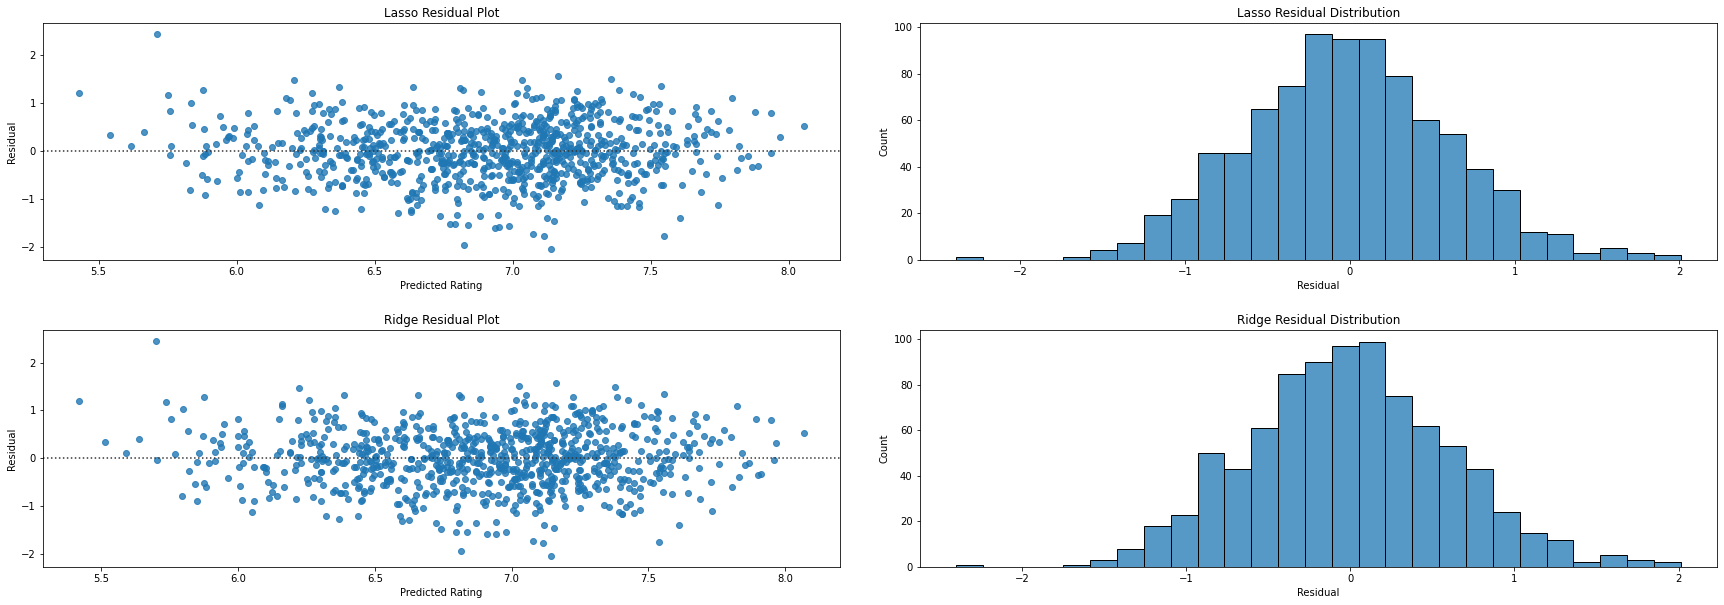

In [19]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['figure.subplot.wspace'] = 0.1
plt.rcParams['figure.subplot.hspace'] = 0.3

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
ax.set(xlabel="Predicted Rating", ylabel="Residual", title="Lasso Residual Plot")
sns.residplot(las_pipe.predict(X_test), y_test, ax=ax)

ax = fig.add_subplot(2, 2, 2)
ax.set(xlabel="Residual", title="Lasso Residual Distribution")
sns.histplot(las_pipe.predict(X_test) - y_test.ravel(), ax=ax)

ax = fig.add_subplot(2, 2, 3)
ax.set(xlabel="Predicted Rating", ylabel="Residual", title="Ridge Residual Plot")
sns.residplot(rid_pipe.predict(X_test), y_test, ax=ax)

ax = fig.add_subplot(2, 2, 4)
ax.set(xlabel="Residual", title="Ridge Residual Distribution")
sns.histplot((rid_pipe.predict(X_test) - y_test).ravel(), ax=ax)

plt.show()

# Choosing Our Best Model

## Dummy Regressor

In [20]:
from sklearn.dummy import DummyRegressor

dummy_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', DummyRegressor())
    ])

dummy_pipe.fit(X_train, y_train)
print("R2 Value: ", dummy_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, dummy_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, dummy_pipe.predict(X_test)))

R2 Value:  -0.00021300676694635534
Mean Squared Error:  0.6033329593202486
Median Absolute Error:  0.5217048054919919


## Random Forest Regressor and Gradient Boost Regressor

In [21]:
rantree_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', RandomForestRegressor(random_state=15, n_jobs=3, n_estimators=1000, criterion='mse', max_depth=14))
    ])

gboost_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', GradientBoostingRegressor(random_state=15, criterion='friedman_mse', loss='huber', max_depth=3))
    ])

rantree_pipe.fit(X_train, y_train.ravel())
gboost_pipe.fit(X_train, y_train.ravel())

print("RANDOM FOREST REGRESSOR\n==============")
print("R2 Value: ", rantree_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, rantree_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, rantree_pipe.predict(X_test)))

print("\nGRADIENT BOOST REGRESSOR\n==============")
print("R2 Value: ", gboost_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, gboost_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, gboost_pipe.predict(X_test)))

RANDOM FOREST REGRESSOR
R2 Value:  0.40984390487580646
Mean Squared Error:  0.3559847961616494
Median Absolute Error:  0.3929732848549863

GRADIENT BOOST REGRESSOR
R2 Value:  0.4328357592834682
Mean Squared Error:  0.34211600674760906
Median Absolute Error:  0.39231696516349057


# Checking the Residuals

C:\Users\Brennan\anaconda3\envs\mal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Brennan\anaconda3\envs\mal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


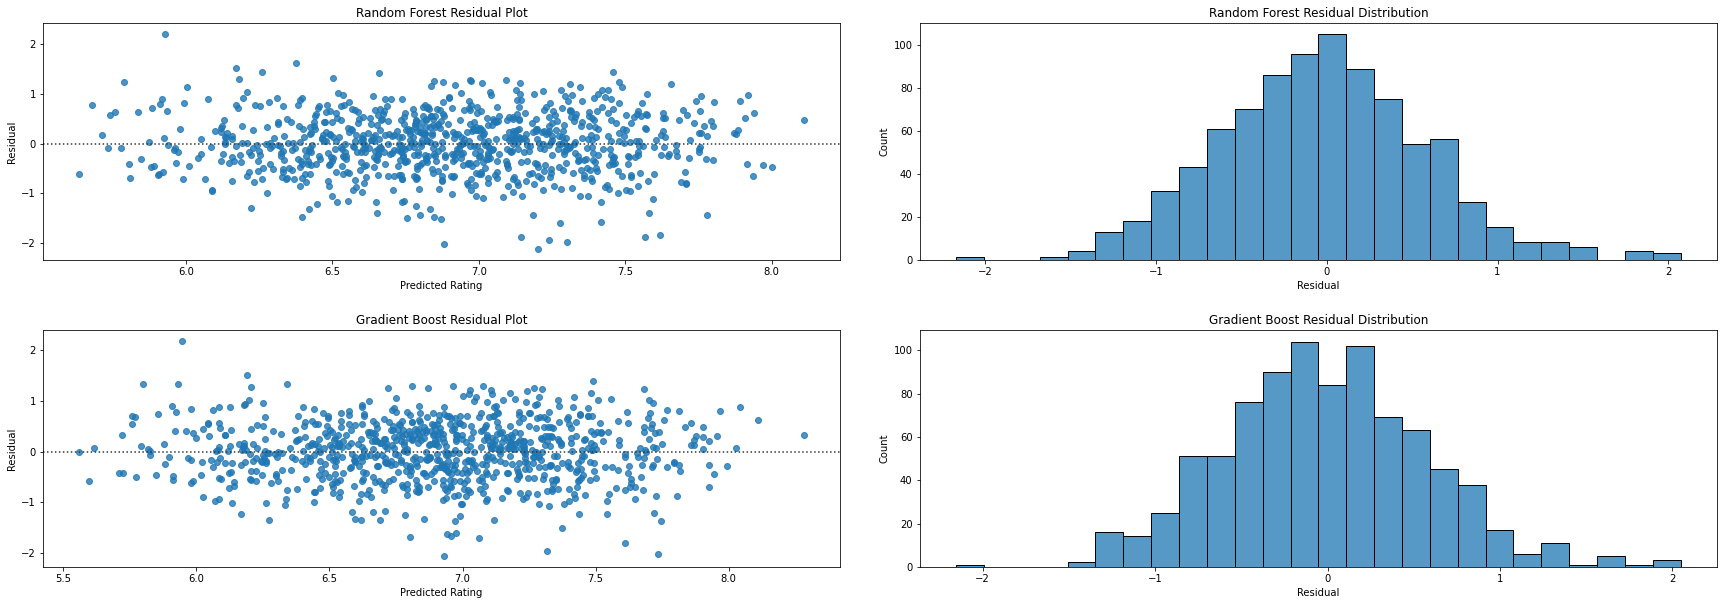

In [22]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['figure.subplot.wspace'] = 0.1
plt.rcParams['figure.subplot.hspace'] = 0.3

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
ax.set(xlabel="Predicted Rating", ylabel="Residual", title="Random Forest Residual Plot")
sns.residplot(rantree_pipe.predict(X_test), y_test, ax=ax)

ax = fig.add_subplot(2, 2, 2)
ax.set(xlabel="Residual", title="Random Forest Residual Distribution")
sns.histplot(rantree_pipe.predict(X_test) - y_test.ravel(), ax=ax)

ax = fig.add_subplot(2, 2, 3)
ax.set(xlabel="Predicted Rating", ylabel="Residual", title="Gradient Boost Residual Plot")
sns.residplot(gboost_pipe.predict(X_test), y_test, ax=ax)

ax = fig.add_subplot(2, 2, 4)
ax.set(xlabel="Residual", title="Gradient Boost Residual Distribution")
sns.histplot(gboost_pipe.predict(X_test) - y_test.ravel(), ax=ax)

plt.show()

# Saving Our Model

In [30]:
import gzip, pickletools

# The output of a regular pickle.dump for our random forest is quite large,
# we can compress it using gzip
with gzip.open("server/artifacts/gboost_pipe.pickle", "wb") as f:
    pickled = pickle.dumps(gboost_pipe)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)
    f.close()

"""Code for loading from a gzipped pickle file"""
# with gzip.open("server/artifacts/gboost_pipe.pickle", 'rb') as f:
#     p = pickle.Unpickler(f)
#     gboost_pipe = p.load()

'Code for loading from a gzipped pickle file'

In [29]:
import json

# Firstly we append our data columns to the json
column_info = {
    'data_columns' : features
}

# Write dict to a json file
with open("server/artifacts/data_columns.json", "w") as f:
    f.write(json.dumps(column_info))

In [32]:
X_test.loc[0, :].ravel()

array([1500, 22, 30, 802, 0.06857142857142856, 0.0, 0.38619047619047614,
       0.0, 2, 4.0, 1.0, 36.45189023030679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       1.0, 0.0, 0, 1.0, 0.0, 0.0, 0.0, 0.0, 1, 'manga'], dtype=object)

In [35]:
gboost_pipe.predict([[1500, 22, 30, 802, 0.06857142857142856, 0.0, 0.38619047619047614,
       0.0, 2, 4.0, 1.0, 36.45189023030679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       1.0, 0.0, 0, 1.0, 0.0, 0.0, 0.0, 0.0, 1, 'manga']])[0]

8.043840343045474